# RNN with NPE, 2 parameters, new model, batch size of 1000, 1 or flattened (batch of 1)

In [1]:
### Define SNPE-C in case we want to edit

# This file is part of sbi, a toolkit for simulation-based inference. sbi is licensed
# under the Affero General Public License v3, see <https://www.gnu.org/licenses/>.


from typing import Callable, Dict, Optional, Union

import torch
from pyknos.mdn.mdn import MultivariateGaussianMDN as mdn
from pyknos.nflows.transforms import CompositeTransform
from torch import Tensor, eye, nn, ones
from torch.distributions import Distribution, MultivariateNormal, Uniform

from sbi import utils as utils
from sbi.inference.posteriors.direct_posterior import DirectPosterior
from sbi.inference.snpe.snpe_base import PosteriorEstimator
from sbi.types import TensorboardSummaryWriter
from sbi.utils import (
    batched_mixture_mv,
    batched_mixture_vmv,
    check_dist_class,
    clamp_and_warn,
    del_entries,
    repeat_rows,
)


class SNPE_C(PosteriorEstimator):
    def __init__(
        self,
        prior: Optional[Distribution] = None,
        density_estimator: Union[str, Callable] = "maf",
        device: str = "cpu",
        logging_level: Union[int, str] = "WARNING",
        summary_writer: Optional[TensorboardSummaryWriter] = None,
        show_progress_bars: bool = True,
    ):
        r"""SNPE-C / APT [1].

        [1] _Automatic Posterior Transformation for Likelihood-free Inference_,
            Greenberg et al., ICML 2019, https://arxiv.org/abs/1905.07488.

        This class implements two loss variants of SNPE-C: the non-atomic and the atomic
        version. The atomic loss of SNPE-C can be used for any density estimator,
        i.e. also for normalizing flows. However, it suffers from leakage issues. On
        the other hand, the non-atomic loss can only be used only if the proposal
        distribution is a mixture of Gaussians, the density estimator is a mixture of
        Gaussians, and the prior is either Gaussian or Uniform. It does not suffer from
        leakage issues. At the beginning of each round, we print whether the non-atomic
        or the atomic version is used.

        In this codebase, we will automatically switch to the non-atomic loss if the
        following criteria are fulfilled:<br/>
        - proposal is a `DirectPosterior` with density_estimator `mdn`, as built
            with `utils.sbi.posterior_nn()`.<br/>
        - the density estimator is a `mdn`, as built with
            `utils.sbi.posterior_nn()`.<br/>
        - `isinstance(prior, MultivariateNormal)` (from `torch.distributions`) or
            `isinstance(prior, sbi.utils.BoxUniform)`

        Note that custom implementations of any of these densities (or estimators) will
        not trigger the non-atomic loss, and the algorithm will fall back onto using
        the atomic loss.

        Args:
            prior: A probability distribution that expresses prior knowledge about the
                parameters, e.g. which ranges are meaningful for them.
            density_estimator: If it is a string, use a pre-configured network of the
                provided type (one of nsf, maf, mdn, made). Alternatively, a function
                that builds a custom neural network can be provided. The function will
                be called with the first batch of simulations (theta, x), which can
                thus be used for shape inference and potentially for z-scoring. It
                needs to return a PyTorch `nn.Module` implementing the density
                estimator. The density estimator needs to provide the methods
                `.log_prob` and `.sample()`.
            device: Training device, e.g., "cpu", "cuda" or "cuda:{0, 1, ...}".
            logging_level: Minimum severity of messages to log. One of the strings
                INFO, WARNING, DEBUG, ERROR and CRITICAL.
            summary_writer: A tensorboard `SummaryWriter` to control, among others, log
                file location (default is `<current working directory>/logs`.)
            show_progress_bars: Whether to show a progressbar during training.
        """

        kwargs = del_entries(locals(), entries=("self", "__class__"))
        super().__init__(**kwargs)

    def train(
        self,
        num_atoms: int = 10,
        training_batch_size: int = 50,
        learning_rate: float = 5e-4,
        validation_fraction: float = 0.1,
        stop_after_epochs: int = 20,
        max_num_epochs: int = 2**31 - 1,
        clip_max_norm: Optional[float] = 5.0,
        calibration_kernel: Optional[Callable] = None,
        resume_training: bool = False,
        force_first_round_loss: bool = False,
        discard_prior_samples: bool = False,
        use_combined_loss: bool = False,
        retrain_from_scratch: bool = False,
        show_train_summary: bool = False,
        dataloader_kwargs: Optional[Dict] = None,
    ) -> nn.Module:
        r"""Return density estimator that approximates the distribution $p(\theta|x)$.

        Args:
            num_atoms: Number of atoms to use for classification.
            training_batch_size: Training batch size.
            learning_rate: Learning rate for Adam optimizer.
            validation_fraction: The fraction of data to use for validation.
            stop_after_epochs: The number of epochs to wait for improvement on the
                validation set before terminating training.
            max_num_epochs: Maximum number of epochs to run. If reached, we stop
                training even when the validation loss is still decreasing. Otherwise,
                we train until validation loss increases (see also `stop_after_epochs`).
            clip_max_norm: Value at which to clip the total gradient norm in order to
                prevent exploding gradients. Use None for no clipping.
            calibration_kernel: A function to calibrate the loss with respect to the
                simulations `x`. See Lueckmann, Gonçalves et al., NeurIPS 2017.
            resume_training: Can be used in case training time is limited, e.g. on a
                cluster. If `True`, the split between train and validation set, the
                optimizer, the number of epochs, and the best validation log-prob will
                be restored from the last time `.train()` was called.
            force_first_round_loss: If `True`, train with maximum likelihood,
                i.e., potentially ignoring the correction for using a proposal
                distribution different from the prior.
            discard_prior_samples: Whether to discard samples simulated in round 1, i.e.
                from the prior. Training may be sped up by ignoring such less targeted
                samples.
            use_combined_loss: Whether to train the neural net also on prior samples
                using maximum likelihood in addition to training it on all samples using
                atomic loss. The extra MLE loss helps prevent density leaking with
                bounded priors.
            retrain_from_scratch: Whether to retrain the conditional density
                estimator for the posterior from scratch each round.
            show_train_summary: Whether to print the number of epochs and validation
                loss and leakage after the training.
            dataloader_kwargs: Additional or updated kwargs to be passed to the training
                and validation dataloaders (like, e.g., a collate_fn)

        Returns:
            Density estimator that approximates the distribution $p(\theta|x)$.
        """

        # WARNING: sneaky trick ahead. We proxy the parent's `train` here,
        # requiring the signature to have `num_atoms`, save it for use below, and
        # continue. It's sneaky because we are using the object (self) as a namespace
        # to pass arguments between functions, and that's implicit state management.
        self._num_atoms = num_atoms
        self._use_combined_loss = use_combined_loss
        kwargs = del_entries(
            locals(),
            entries=("self", "__class__", "num_atoms", "use_combined_loss"),
        )

        self._round = max(self._data_round_index)

        if self._round > 0:
            # Set the proposal to the last proposal that was passed by the user. For
            # atomic SNPE, it does not matter what the proposal is. For non-atomic
            # SNPE, we only use the latest data that was passed, i.e. the one from the
            # last proposal.
            proposal = self._proposal_roundwise[-1]
            self.use_non_atomic_loss = (
                isinstance(proposal, DirectPosterior)
                and isinstance(proposal.posterior_estimator._distribution, mdn)
                and isinstance(self._neural_net._distribution, mdn)
                and check_dist_class(
                    self._prior, class_to_check=(Uniform, MultivariateNormal)
                )[0]
            )

            algorithm = "non-atomic" if self.use_non_atomic_loss else "atomic"
            print(f"Using SNPE-C with {algorithm} loss")

            if self.use_non_atomic_loss:
                # Take care of z-scoring, pre-compute and store prior terms.
                self._set_state_for_mog_proposal()

        return super().train(**kwargs)

    def _set_state_for_mog_proposal(self) -> None:
        """Set state variables that are used at each training step of non-atomic SNPE-C.

        Three things are computed:
        1) Check if z-scoring was requested. To do so, we check if the `_transform`
            argument of the net had been a `CompositeTransform`. See pyknos mdn.py.
        2) Define a (potentially standardized) prior. It's standardized if z-scoring
            had been requested.
        3) Compute (Precision * mean) for the prior. This quantity is used at every
            training step if the prior is Gaussian.
        """

        self.z_score_theta = isinstance(self._neural_net._transform, CompositeTransform)

        self._set_maybe_z_scored_prior()

        if isinstance(self._maybe_z_scored_prior, MultivariateNormal):
            self.prec_m_prod_prior = torch.mv(
                self._maybe_z_scored_prior.precision_matrix,  # type: ignore
                self._maybe_z_scored_prior.loc,  # type: ignore
            )

    def _set_maybe_z_scored_prior(self) -> None:
        r"""Compute and store potentially standardized prior (if z-scoring was done).

        The proposal posterior is:
        $pp(\theta|x) = 1/Z * q(\theta|x) * prop(\theta) / p(\theta)$

        Let's denote z-scored theta by `a`: a = (theta - mean) / std
        Then pp'(a|x) = 1/Z_2 * q'(a|x) * prop'(a) / p'(a)$

        The ' indicates that the evaluation occurs in standardized space. The constant
        scaling factor has been absorbed into Z_2.
        From the above equation, we see that we need to evaluate the prior **in
        standardized space**. We build the standardized prior in this function.

        The standardize transform that is applied to the samples theta does not use
        the exact prior mean and std (due to implementation issues). Hence, the z-scored
        prior will not be exactly have mean=0 and std=1.
        """

        if self.z_score_theta:
            scale = self._neural_net._transform._transforms[0]._scale
            shift = self._neural_net._transform._transforms[0]._shift

            # Following the definintion of the linear transform in
            # `standardizing_transform` in `sbiutils.py`:
            # shift=-mean / std
            # scale=1 / std
            # Solving these equations for mean and std:
            estim_prior_std = 1 / scale
            estim_prior_mean = -shift * estim_prior_std

            # Compute the discrepancy of the true prior mean and std and the mean and
            # std that was empirically estimated from samples.
            # N(theta|m,s) = N((theta-m_e)/s_e|(m-m_e)/s_e, s/s_e)
            # Above: m,s are true prior mean and std. m_e,s_e are estimated prior mean
            # and std (estimated from samples and used to build standardize transform).
            almost_zero_mean = (self._prior.mean - estim_prior_mean) / estim_prior_std
            almost_one_std = torch.sqrt(self._prior.variance) / estim_prior_std

            if isinstance(self._prior, MultivariateNormal):
                self._maybe_z_scored_prior = MultivariateNormal(
                    almost_zero_mean, torch.diag(almost_one_std)
                )
            else:
                range_ = torch.sqrt(almost_one_std * 3.0)
                self._maybe_z_scored_prior = utils.BoxUniform(
                    almost_zero_mean - range_, almost_zero_mean + range_
                )
        else:
            self._maybe_z_scored_prior = self._prior

    def _log_prob_proposal_posterior(
        self,
        theta: Tensor,
        x: Tensor,
        masks: Tensor,
        proposal: DirectPosterior,
    ) -> Tensor:
        """Return the log-probability of the proposal posterior.

        If the proposal is a MoG, the density estimator is a MoG, and the prior is
        either Gaussian or uniform, we use non-atomic loss. Else, use atomic loss (which
        suffers from leakage).

        Args:
            theta: Batch of parameters θ.
            x: Batch of data.
            masks: Mask that is True for prior samples in the batch in order to train
                them with prior loss.
            proposal: Proposal distribution.

        Returns: Log-probability of the proposal posterior.
        """

        if self.use_non_atomic_loss:
            return self._log_prob_proposal_posterior_mog(theta, x, proposal)
        else:
            return self._log_prob_proposal_posterior_atomic(theta, x, masks)

    def _log_prob_proposal_posterior_atomic(
        self, theta: Tensor, x: Tensor, masks: Tensor
    ):
        """Return log probability of the proposal posterior for atomic proposals.

        We have two main options when evaluating the proposal posterior.
            (1) Generate atoms from the proposal prior.
            (2) Generate atoms from a more targeted distribution, such as the most
                recent posterior.
        If we choose the latter, it is likely beneficial not to do this in the first
        round, since we would be sampling from a randomly-initialized neural density
        estimator.

        Args:
            theta: Batch of parameters θ.
            x: Batch of data.
            masks: Mask that is True for prior samples in the batch in order to train
                them with prior loss.

        Returns:
            Log-probability of the proposal posterior.
        """

        batch_size = theta.shape[0]

        num_atoms = int(
            clamp_and_warn("num_atoms", self._num_atoms, min_val=2, max_val=batch_size)
        )

        # Each set of parameter atoms is evaluated using the same x,
        # so we repeat rows of the data x, e.g. [1, 2] -> [1, 1, 2, 2]
        repeated_x = repeat_rows(x, num_atoms)

        # To generate the full set of atoms for a given item in the batch,
        # we sample without replacement num_atoms - 1 times from the rest
        # of the theta in the batch.
        probs = ones(batch_size, batch_size) * (1 - eye(batch_size)) / (batch_size - 1)

        choices = torch.multinomial(probs, num_samples=num_atoms - 1, replacement=False)
        contrasting_theta = theta[choices]

        # We can now create our sets of atoms from the contrasting parameter sets
        # we have generated.
        atomic_theta = torch.cat((theta[:, None, :], contrasting_theta), dim=1).reshape(
            batch_size * num_atoms, -1
        )

        # Evaluate large batch giving (batch_size * num_atoms) log prob posterior evals.
        log_prob_posterior = self._neural_net.log_prob(atomic_theta, repeated_x)
        utils.assert_all_finite(log_prob_posterior, "posterior eval")
        log_prob_posterior = log_prob_posterior.reshape(batch_size, num_atoms)

        # Get (batch_size * num_atoms) log prob prior evals.
        log_prob_prior = self._prior.log_prob(atomic_theta)
        log_prob_prior = log_prob_prior.reshape(batch_size, num_atoms)
        utils.assert_all_finite(log_prob_prior, "prior eval")

        # Compute unnormalized proposal posterior.
        unnormalized_log_prob = log_prob_posterior - log_prob_prior

        # Normalize proposal posterior across discrete set of atoms.
        log_prob_proposal_posterior = unnormalized_log_prob[:, 0] - torch.logsumexp(
            unnormalized_log_prob, dim=-1
        )
        utils.assert_all_finite(log_prob_proposal_posterior, "proposal posterior eval")

        # XXX This evaluates the posterior on _all_ prior samples
        if self._use_combined_loss:
            log_prob_posterior_non_atomic = self._neural_net.log_prob(theta, x)
            masks = masks.reshape(-1)
            log_prob_proposal_posterior = (
                masks * log_prob_posterior_non_atomic + log_prob_proposal_posterior
            )

        return log_prob_proposal_posterior

    def _log_prob_proposal_posterior_mog(
        self, theta: Tensor, x: Tensor, proposal: DirectPosterior
    ) -> Tensor:
        """Return log-probability of the proposal posterior for MoG proposal.

        For MoG proposals and MoG density estimators, this can be done in closed form
        and does not require atomic loss (i.e. there will be no leakage issues).

        Notation:

        m are mean vectors.
        prec are precision matrices.
        cov are covariance matrices.

        _p at the end indicates that it is the proposal.
        _d indicates that it is the density estimator.
        _pp indicates the proposal posterior.

        All tensors will have shapes (batch_dim, num_components, ...)

        Args:
            theta: Batch of parameters θ.
            x: Batch of data.
            proposal: Proposal distribution.

        Returns:
            Log-probability of the proposal posterior.
        """

        # Evaluate the proposal. MDNs do not have functionality to run the embedding_net
        # and then get the mixture_components (**without** calling log_prob()). Hence,
        # we call them separately here.
        encoded_x = proposal.posterior_estimator._embedding_net(proposal.default_x)
        dist = (
            proposal.posterior_estimator._distribution
        )  # defined to avoid ugly black formatting.
        logits_p, m_p, prec_p, _, _ = dist.get_mixture_components(encoded_x)
        norm_logits_p = logits_p - torch.logsumexp(logits_p, dim=-1, keepdim=True)

        # Evaluate the density estimator.
        encoded_x = self._neural_net._embedding_net(x)
        dist = self._neural_net._distribution  # defined to avoid black formatting.
        logits_d, m_d, prec_d, _, _ = dist.get_mixture_components(encoded_x)
        norm_logits_d = logits_d - torch.logsumexp(logits_d, dim=-1, keepdim=True)

        # z-score theta if it z-scoring had been requested.
        theta = self._maybe_z_score_theta(theta)

        # Compute the MoG parameters of the proposal posterior.
        (
            logits_pp,
            m_pp,
            prec_pp,
            cov_pp,
        ) = self._automatic_posterior_transformation(
            norm_logits_p, m_p, prec_p, norm_logits_d, m_d, prec_d
        )

        # Compute the log_prob of theta under the product.
        log_prob_proposal_posterior = utils.mog_log_prob(
            theta, logits_pp, m_pp, prec_pp
        )
        utils.assert_all_finite(
            log_prob_proposal_posterior,
            """the evaluation of the MoG proposal posterior. This is likely due to a
            numerical instability in the training procedure. Please create an issue on
            Github.""",
        )

        return log_prob_proposal_posterior

    def _automatic_posterior_transformation(
        self,
        logits_p: Tensor,
        means_p: Tensor,
        precisions_p: Tensor,
        logits_d: Tensor,
        means_d: Tensor,
        precisions_d: Tensor,
    ):
        r"""Returns the MoG parameters of the proposal posterior.

        The proposal posterior is:
        $pp(\theta|x) = 1/Z * q(\theta|x) * prop(\theta) / p(\theta)$
        In words: proposal posterior = posterior estimate * proposal / prior.

        If the posterior estimate and the proposal are MoG and the prior is either
        Gaussian or uniform, we can solve this in closed-form. The is implemented in
        this function.

        This function implements Appendix A1 from Greenberg et al. 2019.

        We have to build L*K components. How do we do this?
        Example: proposal has two components, density estimator has three components.
        Let's call the two components of the proposal i,j and the three components
        of the density estimator x,y,z. We have to multiply every component of the
        proposal with every component of the density estimator. So, what we do is:
        1) for the proposal, build: i,i,i,j,j,j. Done with torch.repeat_interleave()
        2) for the density estimator, build: x,y,z,x,y,z. Done with torch.repeat()
        3) Multiply them with simple matrix operations.

        Args:
            logits_p: Component weight of each Gaussian of the proposal.
            means_p: Mean of each Gaussian of the proposal.
            precisions_p: Precision matrix of each Gaussian of the proposal.
            logits_d: Component weight for each Gaussian of the density estimator.
            means_d: Mean of each Gaussian of the density estimator.
            precisions_d: Precision matrix of each Gaussian of the density estimator.

        Returns: (Component weight, mean, precision matrix, covariance matrix) of each
            Gaussian of the proposal posterior. Has L*K terms (proposal has L terms,
            density estimator has K terms).
        """

        precisions_pp, covariances_pp = self._precisions_proposal_posterior(
            precisions_p, precisions_d
        )

        means_pp = self._means_proposal_posterior(
            covariances_pp, means_p, precisions_p, means_d, precisions_d
        )

        logits_pp = self._logits_proposal_posterior(
            means_pp,
            precisions_pp,
            covariances_pp,
            logits_p,
            means_p,
            precisions_p,
            logits_d,
            means_d,
            precisions_d,
        )

        return logits_pp, means_pp, precisions_pp, covariances_pp

    def _precisions_proposal_posterior(
        self, precisions_p: Tensor, precisions_d: Tensor
    ):
        """Return the precisions and covariances of the proposal posterior.

        Args:
            precisions_p: Precision matrices of the proposal distribution.
            precisions_d: Precision matrices of the density estimator.

        Returns: (Precisions, Covariances) of the proposal posterior. L*K terms.
        """

        num_comps_p = precisions_p.shape[1]
        num_comps_d = precisions_d.shape[1]

        precisions_p_rep = precisions_p.repeat_interleave(num_comps_d, dim=1)
        precisions_d_rep = precisions_d.repeat(1, num_comps_p, 1, 1)

        precisions_pp = precisions_p_rep + precisions_d_rep
        if isinstance(self._maybe_z_scored_prior, MultivariateNormal):
            precisions_pp -= self._maybe_z_scored_prior.precision_matrix

        covariances_pp = torch.inverse(precisions_pp)

        return precisions_pp, covariances_pp

    def _means_proposal_posterior(
        self,
        covariances_pp: Tensor,
        means_p: Tensor,
        precisions_p: Tensor,
        means_d: Tensor,
        precisions_d: Tensor,
    ):
        """Return the means of the proposal posterior.

        means_pp = C_ix * (P_i * m_i + P_x * m_x - P_o * m_o).

        Args:
            covariances_pp: Covariance matrices of the proposal posterior.
            means_p: Means of the proposal distribution.
            precisions_p: Precision matrices of the proposal distribution.
            means_d: Means of the density estimator.
            precisions_d: Precision matrices of the density estimator.

        Returns: Means of the proposal posterior. L*K terms.
        """

        num_comps_p = precisions_p.shape[1]
        num_comps_d = precisions_d.shape[1]

        # First, compute the product P_i * m_i and P_j * m_j
        prec_m_prod_p = batched_mixture_mv(precisions_p, means_p)
        prec_m_prod_d = batched_mixture_mv(precisions_d, means_d)

        # Repeat them to allow for matrix operations: same trick as for the precisions.
        prec_m_prod_p_rep = prec_m_prod_p.repeat_interleave(num_comps_d, dim=1)
        prec_m_prod_d_rep = prec_m_prod_d.repeat(1, num_comps_p, 1)

        # Means = C_ij * (P_i * m_i + P_x * m_x - P_o * m_o).
        summed_cov_m_prod_rep = prec_m_prod_p_rep + prec_m_prod_d_rep
        if isinstance(self._maybe_z_scored_prior, MultivariateNormal):
            summed_cov_m_prod_rep -= self.prec_m_prod_prior

        means_pp = batched_mixture_mv(covariances_pp, summed_cov_m_prod_rep)

        return means_pp

    @staticmethod
    def _logits_proposal_posterior(
        means_pp: Tensor,
        precisions_pp: Tensor,
        covariances_pp: Tensor,
        logits_p: Tensor,
        means_p: Tensor,
        precisions_p: Tensor,
        logits_d: Tensor,
        means_d: Tensor,
        precisions_d: Tensor,
    ):
        """Return the component weights (i.e. logits) of the proposal posterior.

        Args:
            means_pp: Means of the proposal posterior.
            precisions_pp: Precision matrices of the proposal posterior.
            covariances_pp: Covariance matrices of the proposal posterior.
            logits_p: Component weights (i.e. logits) of the proposal distribution.
            means_p: Means of the proposal distribution.
            precisions_p: Precision matrices of the proposal distribution.
            logits_d: Component weights (i.e. logits) of the density estimator.
            means_d: Means of the density estimator.
            precisions_d: Precision matrices of the density estimator.

        Returns: Component weights of the proposal posterior. L*K terms.
        """

        num_comps_p = precisions_p.shape[1]
        num_comps_d = precisions_d.shape[1]

        # Compute log(alpha_i * beta_j)
        logits_p_rep = logits_p.repeat_interleave(num_comps_d, dim=1)
        logits_d_rep = logits_d.repeat(1, num_comps_p)
        logit_factors = logits_p_rep + logits_d_rep

        # Compute sqrt(det()/(det()*det()))
        logdet_covariances_pp = torch.logdet(covariances_pp)
        logdet_covariances_p = -torch.logdet(precisions_p)
        logdet_covariances_d = -torch.logdet(precisions_d)

        # Repeat the proposal and density estimator terms such that there are LK terms.
        # Same trick as has been used above.
        logdet_covariances_p_rep = logdet_covariances_p.repeat_interleave(
            num_comps_d, dim=1
        )
        logdet_covariances_d_rep = logdet_covariances_d.repeat(1, num_comps_p)

        log_sqrt_det_ratio = 0.5 * (
            logdet_covariances_pp
            - (logdet_covariances_p_rep + logdet_covariances_d_rep)
        )

        # Compute for proposal, density estimator, and proposal posterior:
        # mu_i.T * P_i * mu_i
        exponent_p = batched_mixture_vmv(precisions_p, means_p)
        exponent_d = batched_mixture_vmv(precisions_d, means_d)
        exponent_pp = batched_mixture_vmv(precisions_pp, means_pp)

        # Extend proposal and density estimator exponents to get LK terms.
        exponent_p_rep = exponent_p.repeat_interleave(num_comps_d, dim=1)
        exponent_d_rep = exponent_d.repeat(1, num_comps_p)
        exponent = -0.5 * (exponent_p_rep + exponent_d_rep - exponent_pp)

        logits_pp = logit_factors + log_sqrt_det_ratio + exponent

        return logits_pp

    def _maybe_z_score_theta(self, theta: Tensor) -> Tensor:
        """Return potentially standardized theta if z-scoring was requested."""

        if self.z_score_theta:
            theta, _ = self._neural_net._transform(theta)

        return theta


In [3]:
# PART 1: Edited code from original sbi repos. Functions edited: simulate_for_sbi, and all the functions it contains.
#Main changes: defined simulator_seeded globally rather than within simulate_in_batches function, and re-imported torch within simulator_seeded 
#NO changes need to be made in this file

# PART 2: Essentially the unparallelised code with 2 extra arguments in the simulate_for_sbi line

##################################### PART 1 #########################################
import joblib
import contextlib
import random
import torch
import numpy as np

from torch import Tensor, split, randint, cat
from typing import Any, Callable, Optional, Tuple, Union
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm

import sbi
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os

from sbi.inference import SNLE, prepare_for_sbi
# No longer importing simulate_for_sbi from the package, we use the one defined above
from sbi import utils as utils
from sbi import analysis as analysis

def seed_all_backends(seed: Optional[Union[int, Tensor]] = None) -> None:
    if seed is None:
        seed = int(torch.randint(1_000_000, size=(1,)))
    else:
        # Cast Tensor to int (required by math.random since Python 3.11)
        seed = int(seed)

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

def simulator_seeded(simulator: Callable, theta: Tensor, seed: int) -> Tensor:
    import torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    with torch.random.fork_rng(devices=[]):
        torch.manual_seed(seed)
        return simulator(theta)

def simulate_in_batches(simulator: Callable, theta: Tensor, sim_batch_size: int = 1, num_workers: int = 1,
                        seed: Optional[int] = None, show_progress_bars: bool = True, ) -> Tensor:

    num_sims, *_ = theta.shape
    seed_all_backends(seed)

    if num_sims == 0:
        x = torch.tensor([])
    elif sim_batch_size is not None and sim_batch_size < num_sims:
        batches = split(theta, sim_batch_size, dim=0)

        if num_workers != 1:
            batch_seeds = randint(high=1_000_000, size=(len(batches),))

            with tqdm_joblib(
                tqdm(batches, disable=not show_progress_bars,
                     desc=f"Running {num_sims} simulations in {len(batches)} batches.", total=len(batches),)) as _:
                simulation_outputs = Parallel(n_jobs=num_workers)(delayed(simulator_seeded)(simulator, batch, batch_seed)
                    for batch, batch_seed in zip(batches, batch_seeds))
        else:
            pbar = tqdm(total=num_sims, disable=not show_progress_bars, desc=f"Running {num_sims} simulations.", )

            with pbar:
                simulation_outputs = []
                for batch in batches:
                    simulation_outputs.append(simulator_seeded(simulator, batch, seed))
                    pbar.update(sim_batch_size)

        x = cat(simulation_outputs, dim=0)
    else:
        x = simulator(theta)

    return x


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()

def simulate_for_sbi(simulator: Callable, proposal: Any, num_simulations: int, num_workers: int = 1,
                     simulation_batch_size: int = 1, seed: Optional[int] = None,
                     show_progress_bar: bool = True, ) -> Tuple[Tensor, Tensor]:

    theta = proposal.sample((num_simulations,))

    x = simulate_in_batches(simulator=simulator, theta=theta, sim_batch_size=simulation_batch_size,
                            num_workers=num_workers, seed=seed, show_progress_bars=show_progress_bar,)

    return theta, x

######################################################################################################

simulation_batch_size = 1500
num_simulations = 10000

# To parallelise, set number of CPUs to be used. Note: parallelise anything that has num_rounds>2 and/or num_simulations>50
# to see total available CPUs: print(os.cpu_count())

CPUs_to_use = 8

total_CPUs = os.cpu_count()
num_workers = CPUs_to_use - total_CPUs -1
# num_workers = -1 uses all cpus
# num_workers = -2 uses all cpus but one etc https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html
if CPUs_to_use > total_CPUs:
    raise ValueError(f"Cannot use more CPUs than are available. Available CPUs: {total_CPUs}")

# Now RNN, new model, batch size of 1000, L=1

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

# Define repressilator model
def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params #only 2 ks are parameters to infer
    k3 = 246.96291990024542
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dm1dt = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dp1dt = (b1 * m1) - (dp1 * p1)
    dm2dt = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dp2dt = (b2 * m2) - (dp2 * p2)
    dm3dt = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dp3dt = (b3 * m3)-(dp3 * p3)
    
    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

# Define the true parameters for k
true_params = np.array([
    246.96291990024542, 246.96291990024542,])

# Establish prior from 0-250
num_dim = 2
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))

In [10]:
# We define the time variable (0-100 in 1000 steps), the initial conditions, etc.
num_timesteps = 1000
num_trajectories = 6
initial_conditions = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_timesteps, num_trajectories))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[timestep, i] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data #We can see that simulated trajectories have a shape of [1000, 6].
          #The 'sbi' package will automatically add a batch size to the trajectories so that tensor shape is [1, 1000, 6]

tensor([[  0.0000,   1.0000,   0.0000,   3.0000,   0.0000,   2.0000],
        [  2.3466,   4.8680,   2.3466,   6.7172,   2.3466,   5.7926],
        [  4.4394,  15.6593,   4.4394,  17.3690,   4.4394,  16.5141],
        ...,
        [  0.9443,  34.6693,   1.9822, 357.9927,  21.0713, 746.8439],
        [  1.2064,  35.5436,   1.7790, 337.1067,  21.1389, 759.2465],
        [  1.5425,  37.3237,   1.5972, 317.1701,  21.1992, 770.9217]])

In [11]:
# The embedding net is a RNN consisting of a single layer of 100 GRU units (Cho et al, 2014)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size #Number of GRU units
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False)   #Batch size is specified by the second shape number of input. 
                                                                        #In this case, batch_size = 1000 because input.shape is [1, 1000, 6]. (https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)
                                                                        #Weights are therefore updated after a pass through the entire trajectory
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = torch.zeros(1, 1000, self.hidden_size)  # Number of layers, batch_size and number of GRU units
        gru_out, hn = self.gru(x, h)                # GRU layer, we don't store the hn (hidden state output)
        output = self.linear(gru_out[:, -1, :])     # It is outputting the last hidden state (is it actually? if batch_first = False, it is actually the batch)
                                                    # Then feed into linear layer that outputs (1 x 25). These are taken as a set of 'embeddings'
        return output

# Define RNN
input_size = 6 #We have 6 dimensions
output_size = 25 #We want 1-dimensional embeddings of length = 25 (1x25)
hidden_size = 100 #GRU units

embedding_net = RNN(input_size, hidden_size, output_size)

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 356 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

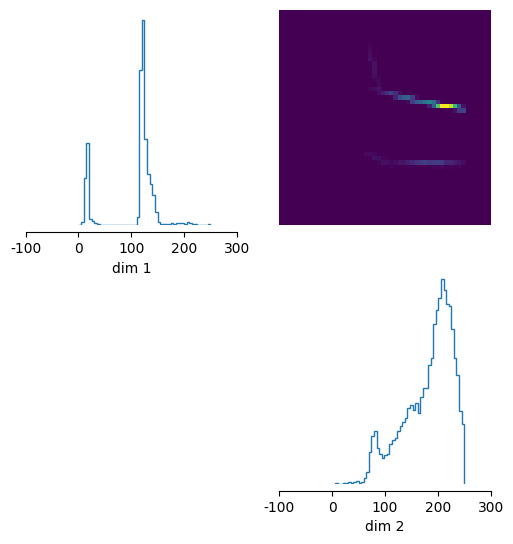

In [12]:
# The prepare for sbi function checks simulator and prior are compatible with the NPE algorithm (and makes sure it adds a batch dimension)
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="mdn", embedding_net=embedding_net, hidden_features=25, num_transforms=2)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=5000) # Simulate data
density_estimator = inference.append_simulations(theta, x).train()        # Train density estimator
posterior = inference.build_posterior(density_estimator)                  # Build posterior

# Then sample the posterior and plot
posterior_samples = posterior.sample((10000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

# Now try with flattened input and a batch size of 1 (?), input of 6000

In [13]:
# We define the time variable (0-100 in 1000 steps), the initial conditions, etc.
num_timesteps = 1000
num_trajectories = 6
initial_conditions = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_trajectories, num_timesteps))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[i, timestep] = solution[timestep][i]
    true_list = []
    for tra in traj: #Erase this loop if we want 6x1000
        for timepoint in tra:
            true_list.append(timepoint)
    true_tensor = torch.Tensor(true_list)
    return true_tensor

true_data = simulator(true_params)
true_data #We can see that simulated trajectories have a shape of [6000].
          #The 'sbi' package will automatically add a batch size to the trajectories so that tensor shape is [1, 6000]

tensor([  0.0000,   2.3466,   4.4394,  ..., 746.8439, 759.2465, 770.9217])

In [14]:
# The embedding net is a RNN consisting of a single layer of 100 GRU units (Cho et al, 2014)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size #Number of GRU units
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)   #Batch size is specified by the second shape number of input. 
                                                                        #In this case, batch_size = 1000 because input.shape is [1, 6000]. (https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)
                                                                        #Weights are therefore updated after a pass through the entire trajectory
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = torch.zeros(1, self.hidden_size)  # Number of layers, batch_size and number of GRU units
        gru_out, hn = self.gru(x, h)                # GRU layer, we don't store the hn (hidden state output)
        output = self.linear(gru_out[:, :])     #Last hidden state
        return output

# Define RNN
input_size = 6000 #We have 6 dimensions
output_size = 25 #We want 1-dimensional embeddings of length = 25 (1x25)
hidden_size = 100 #GRU units

embedding_net = RNN(input_size, hidden_size, output_size)

/project/home23/sg2023/Desktop/SBI/.conda/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:242: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,


Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 128 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

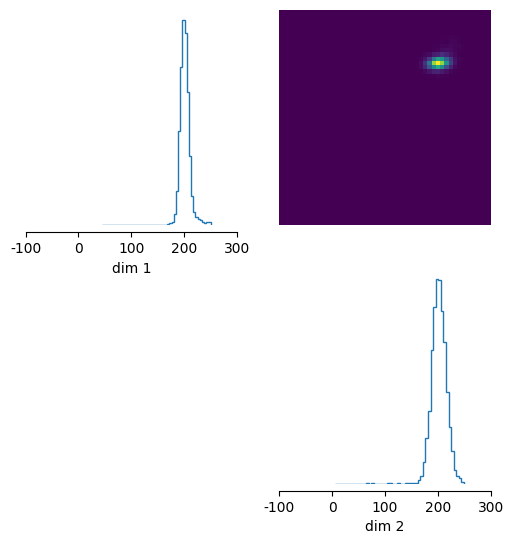

In [15]:
# The prepare for sbi function checks simulator and prior are compatible with the NPE algorithm (and makes sure it adds a batch dimension)
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="mdn", embedding_net=embedding_net, hidden_features=25, num_transforms=2)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=5000) # Simulate data
density_estimator = inference.append_simulations(theta, x).train()        # Train density estimator
posterior = inference.build_posterior(density_estimator)                  # Build posterior

# Then sample the posterior and plot
posterior_samples = posterior.sample((10000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

# Dimension of data (View?)

In [40]:
a = torch.arange(1, 101)
a= a.view(10,10)
a

tensor([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10],
        [ 11,  12,  13,  14,  15,  16,  17,  18,  19,  20],
        [ 21,  22,  23,  24,  25,  26,  27,  28,  29,  30],
        [ 31,  32,  33,  34,  35,  36,  37,  38,  39,  40],
        [ 41,  42,  43,  44,  45,  46,  47,  48,  49,  50],
        [ 51,  52,  53,  54,  55,  56,  57,  58,  59,  60],
        [ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70],
        [ 71,  72,  73,  74,  75,  76,  77,  78,  79,  80],
        [ 81,  82,  83,  84,  85,  86,  87,  88,  89,  90],
        [ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100]])

In [44]:
av = a.view(1,10,10)
av.shape

torch.Size([1, 10, 10])

In [25]:
a

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20])

In [ ]:
#We define the time variable (0-100 in 1000 steps), the initial conditions, etc.
num_timesteps = 1000
num_trajectories = 6
initial_conditions = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_timesteps, num_trajectories))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[timestep, i] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data #We can see that simulated trajectories have a shape of [1000, 6].
          #The 'sbi' package will automatically add a batch size to the trajectories so that tensor shape is [1, 1000, 6]

In [42]:
true_toy = true_data.unsqueeze(0)
toy_reshaped = true_toy.view(-1,1000,6) #-1 flattens the input

In [43]:
toy_reshaped.shape

torch.Size([1, 1000, 6])

In [44]:
toy_reshaped

tensor([[[  0.0000,   2.3466,   4.4394,   6.3059,   7.9700,   9.4510],
         [ 10.7573,  11.8748,  12.7536,  13.3147,  13.4989,  13.3225],
         [ 12.8709,  12.2485,  11.5416,  10.8099,  10.0912,   9.4082],
         ...,
         [457.3617, 482.8732, 507.5988, 531.4787, 554.4693, 576.5410],
         [597.6765, 617.8684, 637.1184, 655.4352, 672.8333, 689.3323],
         [704.9555, 719.7291, 733.6819, 746.8439, 759.2465, 770.9217]]])

In [13]:
# We define the time variable (0-100 in 1000 steps), the initial conditions, etc.
num_timesteps = 1000
num_trajectories = 6
initial_conditions = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_trajectories, num_timesteps))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[i, timestep] = solution[timestep][i]
    true_list = []
    for tra in traj: #Erase this loop if we want 6x1000
        for timepoint in tra:
            true_list.append(timepoint)
    true_tensor = torch.Tensor(true_list)
    return true_tensor

true_data = simulator(true_params)
true_data #We can see that simulated trajectories have a shape of [6000].
          #The 'sbi' package will automatically add a batch size to the trajectories so that tensor shape is [1, 6000]

tensor([  0.0000,   2.3466,   4.4394,  ..., 746.8439, 759.2465, 770.9217])

In [18]:
toy_flat = true_data.unsqueeze(0)
toy_flat_reshaped = toy_flat.view(100, 60, 1)

In [19]:
toy_flat_reshaped.shape

torch.Size([100, 60, 1])

In [52]:
toy_flat_reshaped

tensor([[[[0.0000e+00, 2.3466e+00, 4.4394e+00, 6.3059e+00, 7.9700e+00,
           9.4510e+00],
          [1.0757e+01, 1.1875e+01, 1.2754e+01, 1.3315e+01, 1.3499e+01,
           1.3322e+01],
          [1.2871e+01, 1.2249e+01, 1.1542e+01, 1.0810e+01, 1.0091e+01,
           9.4082e+00],
          ...,
          [6.8680e+00, 6.9277e+00, 6.9735e+00, 7.0064e+00, 7.0275e+00,
           7.0381e+00],
          [7.0397e+00, 7.0338e+00, 7.0217e+00, 7.0048e+00, 6.9843e+00,
           6.9611e+00],
          [6.9361e+00, 6.9100e+00, 6.8832e+00, 6.8561e+00, 6.8288e+00,
           6.8015e+00]],

         [[6.7740e+00, 6.7463e+00, 6.7181e+00, 6.6892e+00, 6.6593e+00,
           6.6281e+00],
          [6.5954e+00, 6.5610e+00, 6.5248e+00, 6.4865e+00, 6.4461e+00,
           6.4038e+00],
          [6.3595e+00, 6.3134e+00, 6.2659e+00, 6.2173e+00, 6.1679e+00,
           6.1184e+00],
          ...,
          [7.3944e+00, 7.6801e+00, 7.9923e+00, 8.3302e+00, 8.6925e+00,
           9.0773e+00],
          [9.4823e

In [12]:
toy_rereshape = toy_flat_reshaped.squeeze()
toy_rereshape.shape

NameError: name 'toy_flat_reshaped' is not defined

# Variant of above, use squeeze

In [45]:
# We define the time variable (0-100 in 1000 steps), the initial conditions, etc.
num_timesteps = 1000
num_trajectories = 6
initial_conditions = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_trajectories, num_timesteps))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[i, timestep] = solution[timestep][i]
    true_list = []
    for tra in traj: #Erase this loop if we want 6x1000
        for timepoint in tra:
            true_list.append(timepoint)
    output = torch.Tensor(true_list)
    output = output.view(100, 60, 1)
    return output

true_data = simulator(true_params)
true_data.shape #We can see that simulated trajectories have a shape of [6000].
          #The 'sbi' package will automatically add a batch size to the trajectories so that tensor shape is [1, 6000]

torch.Size([100, 60, 1])

In [46]:
true_data

tensor([[[0.0000e+00],
         [2.3466e+00],
         [4.4394e+00],
         ...,
         [6.8561e+00],
         [6.8288e+00],
         [6.8015e+00]],

        [[6.7740e+00],
         [6.7463e+00],
         [6.7181e+00],
         ...,
         [1.3383e+01],
         [1.3759e+01],
         [1.4104e+01]],

        [[1.4415e+01],
         [1.4684e+01],
         [1.4904e+01],
         ...,
         [2.7479e-01],
         [2.9420e-01],
         [3.2419e-01]],

        ...,

        [[1.2408e+02],
         [1.1586e+02],
         [1.0816e+02],
         ...,
         [6.8926e+02],
         [7.0489e+02],
         [7.1966e+02]],

        [[7.3362e+02],
         [7.4678e+02],
         [7.5919e+02],
         ...,
         [1.1582e+02],
         [1.0812e+02],
         [1.0092e+02]],

        [[9.4175e+01],
         [8.7875e+01],
         [8.1992e+01],
         ...,
         [7.4684e+02],
         [7.5925e+02],
         [7.7092e+02]]])

In [26]:

true_data = true_data.squeeze() #now 6000
true_data = true_data.view(100, 60, 1)
true_data.shape

torch.Size([100, 60, 1])

In [50]:
# The embedding net is a RNN consisting of a single layer of 100 GRU units (Cho et al, 2014)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size #Number of GRU units
        self.input_size = input_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)   #Batch size is specified by the second shape number of input. 
                                                                        #In this case, batch_size = 1000 because input.shape is [1, 6000]. (https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)
                                                                        #Weights are therefore updated after a pass through the entire trajectory
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.squeeze()
        h = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # Number of layers, batch_size and number of GRU units
        gru_out, _ = self.gru(x, h)                # GRU layer, we don't store the hn (hidden state output)
        output = self.linear(gru_out[:,-1, :])     #Last hidden state
        return output

# Define RNN
num_layers = 1
input_size = 1
batch_size = 100
output_size = 25 #We want 1-dimensional embeddings of length = 25 (1x25)
hidden_size = 100 #GRU units

embedding_net = RNN(input_size, hidden_size, output_size, num_layers)

In [51]:
# The prepare for sbi function checks simulator and prior are compatible with the NPE algorithm (and makes sure it adds a batch dimension)
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="mdn", embedding_net=embedding_net, hidden_features=25, num_transforms=2)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=4) # Simulate data
density_estimator = inference.append_simulations(theta, x).train()        # Train density estimator
posterior = inference.build_posterior(density_estimator)                  # Build posterior

# Then sample the posterior and plot
posterior_samples = posterior.sample((10000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

/project/home23/sg2023/Desktop/SBI/.conda/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:242: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,


Running 4 simulations.:   0%|          | 0/4 [00:00<?, ?it/s]

RuntimeError: For unbatched 2-D input, hx should also be 2-D but got 3-D tensor

In [13]:
toy = true_data.unsqueeze(0)
toyt = torch.transpose(toy, 0, 1)
toyt

tensor([[  0.0000],
        [  2.3466],
        [  4.4394],
        ...,
        [746.8439],
        [759.2465],
        [770.9217]])

# Now try with a batch size of 1, NOT WORKING!

In [ ]:
# We define the time variable (0-100 in 1000 steps), the initial conditions, etc.
num_timesteps = 1000
num_trajectories = 6
initial_conditions = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_timesteps, num_trajectories))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[timestep, i] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data #We can see that simulated trajectories have a shape of [1000, 6].
          #The 'sbi' package will automatically add a batch size to the trajectories so that tensor shape is [1, 1000, 6]

tensor([[  0.0000,   1.0000,   0.0000,   3.0000,   0.0000,   2.0000],
        [  2.3466,   4.8680,   2.3466,   6.7172,   2.3466,   5.7926],
        [  4.4394,  15.6593,   4.4394,  17.3690,   4.4394,  16.5141],
        ...,
        [  0.9443,  34.6693,   1.9822, 357.9927,  21.0713, 746.8439],
        [  1.2064,  35.5436,   1.7790, 337.1067,  21.1389, 759.2465],
        [  1.5425,  37.3237,   1.5972, 317.1701,  21.1992, 770.9217]])

In [ ]:
true_data.shape

torch.Size([1000, 6])

In [ ]:
# The embedding net is a RNN consisting of a single layer of 100 GRU units (Cho et al, 2014)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size #Number of GRU units
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)   #Batch size is specified by the second shape number of input. 
                                                                        #In this case, batch_size = 1000 because input.shape is [1, 1000, 6]. (https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)
                                                                        #Weights are therefore updated after a pass through the entire trajectory
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = torch.zeros(1, 1, self.hidden_size)  # Number of layers, batch_size and number of GRU units
        gru_out, hn = self.gru(x, h)                # GRU layer, we don't store the hn (hidden state output)
        output = self.linear(gru_out[:, -1, :])     # It is outputting the last hidden state (timepoint 1000) for each GRU unit (1 x 100).
                                                    # Then feed into linear layer that outputs (1 x 25). These are taken as a set of 'embeddings'
        return output

# Define RNN
input_size = 6 #We have 6 dimensions
output_size = 25 #We want 1-dimensional embeddings of length = 25 (1x25)
hidden_size = 100 #GRU units

embedding_net = RNN(input_size, hidden_size, output_size)

In [ ]:
#Check embedding net
toy_6dim = true_data.unsqueeze(0) #shape [1, 1000, 6]
gru = nn.GRU(input_size, hidden_size, batch_first=True)
linear = nn.Linear(hidden_size, output_size)
h = torch.zeros(1, 1, 100)
gru_out, hn = gru(toy_6dim, h)
output = linear(gru_out[:,-1, :])
output.shape

torch.Size([1, 25])

In [ ]:
# The prepare for sbi function checks simulator and prior are compatible with the NPE algorithm (and makes sure it adds a batch dimension)
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="mdn", embedding_net=embedding_net, hidden_features=25, num_transforms=2)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=3) # Simulate data
density_estimator = inference.append_simulations(theta, x).train()        # Train density estimator
posterior = inference.build_posterior(density_estimator)                  # Build posterior

# Then sample the posterior and plot
posterior_samples = posterior.sample((10000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

/project/home23/sg2023/Desktop/SBI/.conda/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:242: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,


Running 3 simulations.:   0%|          | 0/3 [00:00<?, ?it/s]

RuntimeError: (RuntimeError('Expected hidden size (1, 2, 100), got [1, 1, 100]'), 'Debug hint: The simulated data x has 2 dimensions.\n            With default settings, sbi cannot deal with multidimensional simulations.\n            Make sure to use an embedding net that reduces the dimensionality, e.g., a\n            CNN in case of images, or change the simulator to return one-dimensional x.\n            ')